In [1]:
from hypothesaes.llm_local import _get_engine
from hypothesaes.utils import get_text_for_printing

# model = "google/gemma-3-1b-it"
model = "Qwen/Qwen3-8B"
# model = "Qwen/Qwen3-0.6B"
engine = _get_engine(model)
tokenizer = engine.get_tokenizer()

Loading Qwen/Qwen3-8B in vLLM...
WARNING 07-10 20:13:39 [topk_topp_sampler.py:59] FlashInfer is not available. Falling back to the PyTorch-native implementation of top-p & top-k sampling. For the best performance, please install FlashInfer.


Loading safetensors checkpoint shards:   0% Completed | 0/5 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  20% Completed | 1/5 [00:10<00:41, 10.43s/it]
Loading safetensors checkpoint shards:  40% Completed | 2/5 [00:18<00:26,  8.97s/it]
Loading safetensors checkpoint shards:  60% Completed | 3/5 [00:28<00:18,  9.32s/it]
Loading safetensors checkpoint shards:  80% Completed | 4/5 [00:31<00:06,  6.92s/it]
Loading safetensors checkpoint shards: 100% Completed | 5/5 [00:41<00:00,  8.03s/it]
Loading safetensors checkpoint shards: 100% Completed | 5/5 [00:41<00:00,  8.27s/it]

Capturing CUDA graph shapes: 100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


Loaded Qwen/Qwen3-8B (dtype: torch.bfloat16)


In [2]:
import os
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score, average_precision_score

os.environ['OPENAI_KEY_SAE'] = os.environ['OAI_GENERAL']

current_dir = os.getcwd()
if current_dir.endswith("notebooks"):
    prefix = "../"
else:
    prefix = "./"

df = pd.read_json(os.path.join(prefix, "demo-data", "yelp-demo-val-2K.json"), lines=True)

texts = df['text'].tolist()
labels = df['stars'].values

In [3]:
from hypothesaes.utils import load_prompt
from time import time
from vllm import SamplingParams

simple_prompt = load_prompt('annotate-simple')
base_prompt = load_prompt('annotate')
concept = 'mentions a waiter or waitress by name'
texts_to_annotate = texts[:2000]

sampling_params = SamplingParams(max_tokens=1, temperature=0.0)
sampling_params_thinking = SamplingParams(max_tokens=500, temperature=0.0)

prompts = [base_prompt.format(hypothesis=concept, text=text) for text in texts_to_annotate]
prompts_messages_list = [[{'role': 'user', 'content': p}] for p in prompts]
prompts_chat_format_base = [tokenizer.apply_chat_template(p, tokenize=False, add_generation_prompt=True, enable_thinking=False) for p in prompts_messages_list]
prompts_chat_format_thinking = [tokenizer.apply_chat_template(p, tokenize=False, add_generation_prompt=True, enable_thinking=True) for p in prompts_messages_list]

def parse_response(response: str) -> int:
    if '</think>' in response:
        response = response.split('</think>')[1].strip()
    response = response.strip().lower()
    return 1 if response.startswith("yes") else 0 if response.startswith("no") else None

df_annot = pd.DataFrame()

In [4]:
from hypothesaes.annotate import annotate

start = time()
ground_truth = annotate([(text, concept) for text in texts_to_annotate], model='gpt-4.1', n_workers=50)
print(f"Time taken: {time() - start:.1f}s")

y_gt = np.array([ground_truth[concept][text] for text in texts_to_annotate])
df_annot['ground_truth'] = y_gt

Found 0 cached items; annotating 2000 uncached items


Annotating:   0%|          | 0/2000 [00:00<?, ?it/s]

Time taken: 90.0s


In [5]:
def score_results(parsed_outputs, y_gt):
    valid_mask = np.isin(parsed_outputs, [0, 1])
    print(f"- % valid (0 or 1): {np.mean(valid_mask):.3f} ({np.sum(valid_mask)}/{len(parsed_outputs)})")
    r, p = pearsonr(parsed_outputs[valid_mask].astype(float), y_gt[valid_mask].astype(float))
    print(f"- r, p = Pearson correlation: {r:.3f}, {p:.3f}")
    print(f"- auroc: {roc_auc_score(y_gt[valid_mask], parsed_outputs[valid_mask]):.2f}")
    print(f"- auprc: {average_precision_score(y_gt[valid_mask], parsed_outputs[valid_mask]):.2f}")

if 'parsed_completions' not in df_annot.columns:
    start = time()
    outputs_completions = engine.generate(prompts, sampling_params=sampling_params)
    print(f"engine.generate() without chat turns: {time() - start:.1f}s")
    parsed_completions = np.array([parse_response(output.outputs[0].text) for output in outputs_completions])
    df_annot['parsed_completions'] = parsed_completions
score_results(parsed_completions, y_gt)
# for text, output in zip(texts_to_annotate, outputs_base):
#     print(f"  - {get_text_for_printing(text, max_chars=50)}: {get_text_for_printing(output.outputs[0].text)}")

if 'parsed_chat_manual' not in df_annot.columns:
    start = time()
    outputs_chat_manual = engine.generate(prompts_chat_format_base, sampling_params=sampling_params)
    print(f"engine.generate() manually writing chat format: {time() - start:.1f}s")
    parsed_chat_manual = np.array([parse_response(output.outputs[0].text) for output in outputs_chat_manual])
    df_annot['parsed_chat_manual'] = parsed_chat_manual
score_results(parsed_chat_manual, y_gt)
# for text, output in zip(texts_to_annotate, outputs_chat_manual):
#     print(f"  - {get_text_for_printing(text, max_chars=50)}: {get_text_for_printing(output.outputs[0].text, max_chars=100)}")

if 'parsed_chat_builtin' not in df_annot.columns:
    start = time()
    outputs_chat = engine.chat(prompts_messages_list, sampling_params=sampling_params, chat_template_kwargs={'enable_thinking': False})
    print(f"engine.chat() with chat turns: {time() - start:.1f}s")
    parsed_chat_builtin = np.array([parse_response(output.outputs[0].text) for output in outputs_chat])
    df_annot['parsed_chat_builtin'] = parsed_chat_builtin
score_results(parsed_chat_builtin, y_gt)
# for text, output in zip(texts_to_annotate, outputs_chat):
#     print(f"  - {get_text_for_printing(text, max_chars=50)}: {get_text_for_printing(output.outputs[0].text, max_chars=100)}")

if 'parsed_chat_manual_thinking' not in df_annot.columns:
    start = time()
    outputs_chat_manual_thinking = engine.generate(prompts_chat_format_thinking, sampling_params=sampling_params_thinking)
    print(f"engine.generate() with thinking: {time() - start:.1f}s")
    parsed_chat_manual_thinking = np.array([parse_response(output.outputs[0].text) for output in outputs_chat_manual_thinking])
    df_annot['parsed_chat_manual_thinking'] = parsed_chat_manual_thinking
score_results(parsed_chat_manual_thinking, y_gt)
# for text, output in zip(texts_to_annotate, outputs_chat_manual):
#     print(f"  - {get_text_for_printing(text, max_chars=50)}: {get_text_for_printing(output.outputs[0].text, max_chars=100)}")

Adding requests:   0%|          | 0/2000 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2000 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

engine.generate() without chat turns: 36.4s
- % valid (0 or 1): 1.000 (2000/2000)
- r, p = Pearson correlation: 0.539, 0.000
- auroc: 0.89
- auprc: 0.34


Adding requests:   0%|          | 0/2000 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2000 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

engine.generate() manually writing chat format: 40.1s
- % valid (0 or 1): 1.000 (2000/2000)
- r, p = Pearson correlation: 0.530, 0.000
- auroc: 0.93
- auprc: 0.32


Adding requests:   0%|          | 0/2000 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2000 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

engine.chat() with chat turns: 43.6s
- % valid (0 or 1): 1.000 (2000/2000)
- r, p = Pearson correlation: 0.530, 0.000
- auroc: 0.93
- auprc: 0.32


Adding requests:   0%|          | 0/2000 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2000 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

engine.generate() with thinking: 209.4s
- % valid (0 or 1): 0.997 (1994/2000)
- r, p = Pearson correlation: 0.885, 0.000
- auroc: 0.96
- auprc: 0.80


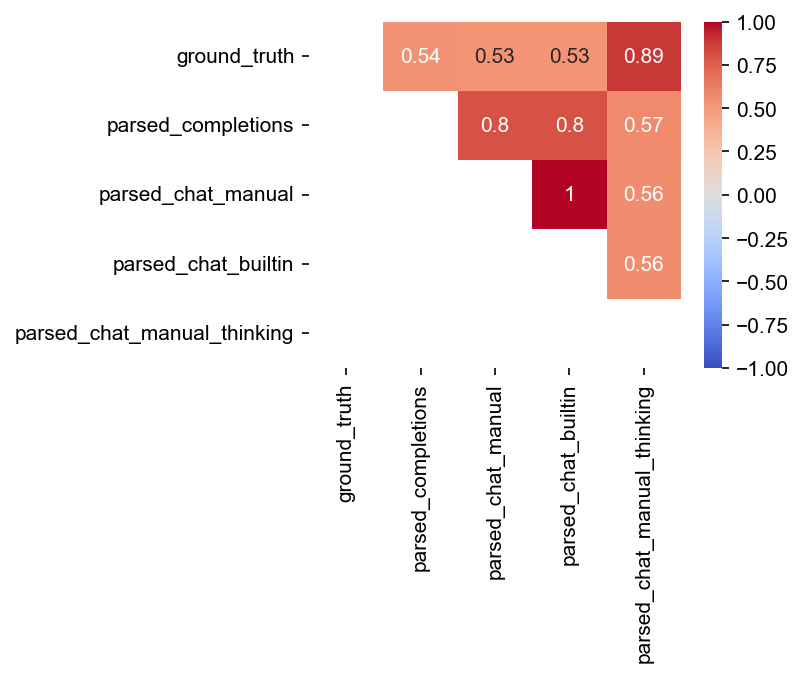

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix for all numeric columns
corr = df_annot.corr()

# Plot triangular (lower triangle) heatmap
mask = np.tril(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(4, 3), dpi=150)
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()
